# Plotting Positions of Galaxy Cluster Memberin DC2 Run 1.1p extra-galactic catalog (protoDC2)

In this example script we show how to select for and look at members of individual clusters.

Owners: **Dan Korytov [@dkorytov](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@dkorytov)**, **Patricia Larsen**

Last verified run: **7-19-18**

This notebook demonstrates how to access the extra galactic catalog through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how filter on galaxy features and cluster membership.

__Objectives__:

After working through and studying this Notebook you should be able to

1. Access extra galactic catalog (ProtoDC2) through the GCR.
2. Select galaxy cluster centrals as a proxy for clusters.
3. Select galaxies in individual clusters by using the host_id quantity.
4. Plotting galaxy clustermembers positions on the sky as well as their comoving position in space.


__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

In [43]:
import GCRCatalogs
import numpy as np
from astropy import table
from GCR import GCRQuery
import matplotlib.pyplot as plt
%matplotlib inline

### Reading catalog
We load in the catalog with the "load_catalog" command, and then the values with the "get_quantities" command using filters to select sub-samples of the catalog.  

### Help for error messages:
If this fails to find the appropriate quantities, check that the desc-python kernel is being used and if this is not available source the kernels by running the following command on a terminal at nersc: "source /global/common/software/lsst/common/miniconda/setup_current_python.sh"

We are loading in the test version of the protoDC2 catalog - this contains the same information as the full catalog but it skips the md5sum check to save time. The resulting warning can be safely ignored. 

In [44]:
gc = GCRCatalogs.load_catalog('protoDC2_test')
galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_r','halo_id'],filters=['mag_r < 19'])
cluster_data = gc.get_quantities(['ra','dec', 'halo_mass','halo_id'], 
                                 filters=['is_central','halo_mass > 1e14', 'redshift < 0.2'])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


### Plot individual clusters
The cluster_data we loaded selects for central galaxies in clusters of mass higher than 10^14 solar masses/h below redshift 0.2. We will plot three such clusters in the proto-DC2 region. 

For each of these clusters we can match the galaxies by selecting on 'halo_id' and make a scatter plot of the projected positions around the central galaxy. Note that the size of the circles corresponds to the r-band magnitude of the galaxies. 

The cluster data is cast into a familiar astropy table.

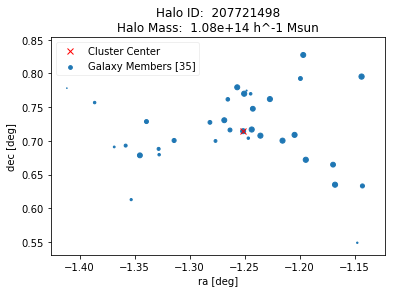

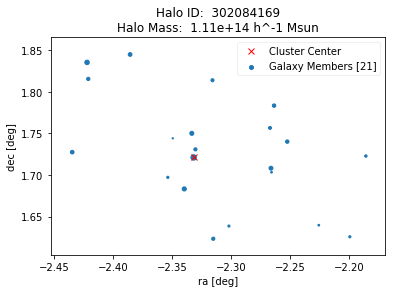

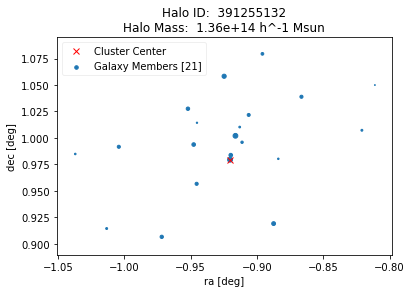

In [45]:
cluster_data = astropy.table.Table(cluster_data)
for i, cluster in enumerate(cluster_data):
    if (i >= 3):
        break # plot only the first 3
    members = GCRQuery('halo_id == {}'.format(cluster['halo_id'])).filter(galaxy_data)
    plt.figure()
    plt.scatter(
        members['ra'], 
        members['dec'], 
        s=(19-members['mag_r'])*8, 
        label='Galaxy Members [{}]'.format(len(members['ra']))
    )
    plt.plot(cluster['ra'], cluster['dec'], 'xr', label='Cluster Center')
    plt.legend(loc='best', framealpha=0.3)
    plt.xlabel(r'ra [deg]')
    plt.ylabel(r'dec [deg]')
    plt.title('Halo ID:  {}\nHalo Mass:  {:.2e} h^-1 Msun'.format(cluster['halo_id'], cluster['halo_mass']))
        
plt.show()

### Extensions:
We can load further information on the cluster members. For instance the second cluster looks a little odd in projected space, so we re-make these plots in comoving cartesian coordinates x and y in the example below. We also map the colours to the x-direction velocities. 

To do this you need to load the required quantities from the catalog before using them. A simple way to double check the quantity names is the command "gc.list_all_quantities()".

In this example, the data is not cast into an astropy table.

In [46]:
#gc.list_all_quantities()
galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_r','halo_id','position_x','position_y','velocity_x','velocity_y'],filters=['mag_r < 19'])
cluster_data = gc.get_quantities(['ra','dec', 'halo_mass','halo_id','position_x','position_y'], 
                                 filters=['isCentral','halo_mass > 1e14', 'redshift < 0.2'])


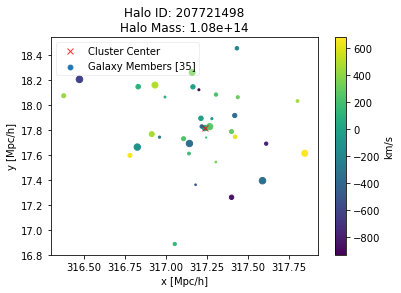

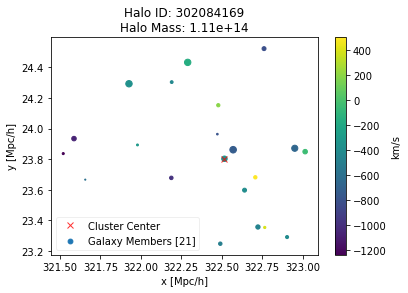

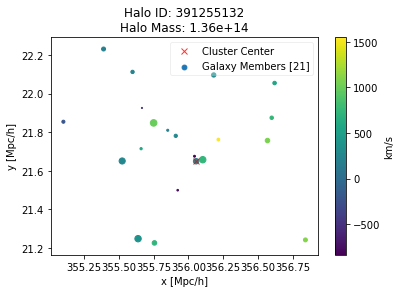

In [47]:
vel_x = np.array(galaxy_data['velocity_x'])
for i in range(0, len(cluster_data['position_x'])):
    if(i>=3):
        break #plot only 3 examples
    x,y = cluster_data['position_x'][i], cluster_data['position_y'][i]
    halo_id, halo_mass = cluster_data['halo_id'][i], cluster_data['halo_mass'][i]
    slct_clstr = galaxy_data['halo_id']==halo_id
    plt.figure()
    plt.scatter(galaxy_data['position_x'][slct_clstr], galaxy_data['position_y'][slct_clstr],
                s=(19-galaxy_data['mag_r'])*8, label ='Galaxy Members [{}]'.format(np.sum(slct_clstr)),
               c = vel_x[slct_clstr],cmap='viridis')
    plt.plot(x,y,'xr',label='Cluster Center', alpha=0.8)
    plt.legend(loc='best',framealpha=0.3)
    plt.xlabel(r'x [Mpc/h]')
    plt.ylabel(r'y [Mpc/h]')
    plt.title('Halo ID: {}\nHalo Mass: {:.2e}'.format(halo_id, halo_mass))
    plt.colorbar(label='km/s')

        
plt.show()